In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from abnativ.model.alignment.mybio import distance_matrix_from_aligned_sequences
import scipy.stats

from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from nanomelt.model.nanomelt import NanoMeltPredPipe

folder_figures = '../figures'

/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data into a fasta file
fp_csv = '../datasets/NanoMelt_83_external_dataset.csv'

data_excel = pd.read_csv(fp_csv)
sequences = data_excel['Sequence']
tms = data_excel['Measured Tm (C) ']
ids = data_excel['Id']

recs = list()
for k, seq in enumerate(sequences):
    id = ids[k] + '_' + str(tms[k])
    recs.append(SeqRecord(Seq(seq), id=id, description=''))



In [4]:
import importlib.resources as pkg_resources
# Run NanoMelt
dict_submodels = {
    'SVR_esm1b': 'esm1b',
    'SVR_esm2_t30': 'esm2_t30',
    'GPR_vhse': 'vhse',
    'GPR_onehot': 'onehot',
                }

# NanoMelt final trained model  as in the original paper
with pkg_resources.path('nanomelt.model.saved_models', 'NanoMelt_finalmodel') as model_path:
    folder_saved_models = str(model_path)
    
batch_size = 128
ncpus = 1
do_align = True

# Run the model
data = NanoMeltPredPipe(recs, batch_size, dict_submodels,
                folder_saved_models, do_align, ncpus)


In [5]:
# Results from true tops
results = data

saved_trues, saved_preds, saved_errs = list(), list(), list()
for id in results['ID']:
    true_tm  = id.split('_')[-1]
    saved_trues.append(float(true_tm))

df_res = pd.DataFrame({'true': saved_trues, 'pred': results['NanoMelt Tm (C)'],
                       'source': data_excel['Source'], 'method': data_excel['Technique']})
al_seqs = results['Aligned Sequence']

print(results.columns)
print(data.columns)
print(data_excel.columns)


Index(['ID', 'Aligned Sequence', 'Sequence', 'NanoMelt Tm (C)'], dtype='object')
Index(['ID', 'Aligned Sequence', 'Sequence', 'NanoMelt Tm (C)'], dtype='object')
Index(['Id', 'Sequence', 'Measured Tm (C) ', 'Technique', 'Solvent', 'pH',
       'Concentration', 'Expression', 'Source', 'Comment'],
      dtype='object')


<ipython-input-6-61a86a5e0bb4>:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plotscatter = sns.scatterplot(df_res, x='true', y='pred', palette=palette, ax=ax, alpha=1,s=70)


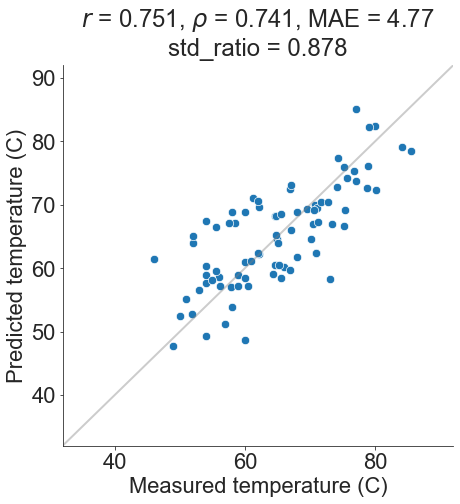

In [6]:
from sklearn.metrics import mean_absolute_error


def perf_metrix(predictions: list, true_values: list):
    '''Compute various prediction performances metrics.'''
    
    pearson, pearson_p = scipy.stats.pearsonr(predictions, true_values)
    spearman, spearman_p = scipy.stats.spearmanr(predictions, true_values)
    mae = mean_absolute_error(predictions, true_values)
    
    pearson = float("{0:.3g}".format(pearson))
    pearson_p = float("{0:.3g}".format(pearson_p))
    spearman = float("{0:.3g}".format(spearman))
    spearman_p = float("{0:.3g}".format(spearman_p))
    mae = float("{0:.3g}".format(mae))
    std_ratio = float("{0:.3g}".format(np.std(predictions)/np.std(true_values)))
    
    return pearson, pearson_p, spearman, spearman_p, mae



# Plot error bars
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
fig, ax = plt.subplots(figsize=(7, 7))
palette="tab10"

ax.plot([0,200], [0,200], '-', color='grey', alpha=0.4, linewidth=2)

for i in range(len(df_res)):
    ax.errorbar(df_res['true'][i], df_res['pred'][i], fmt='none', linewidth=2, alpha=0.15)

# Scatter plot of predictions
plotscatter = sns.scatterplot(df_res, x='true', y='pred', palette=palette, ax=ax, alpha=1,s=70)

# Set title and labels
pearson_latex = r'$r$'
spearman_latex = r'$\rho$'
ax.set_ylabel('Predicted temperature (C)', fontsize=22)
ax.set_xlabel('Measured temperature (C)', fontsize=22)
ax.set_xlim(32,92)
ax.set_ylim(32,92)


std_ratio = "{0:.3g}".format(np.std(df_res['pred'])/np.std(df_res['true']))
pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(df_res['pred'], df_res['true'])

ax.set_title(f"{pearson_latex} = {pearson}, {spearman_latex} = {spearman}, MAE = {rmse} \nstd_ratio = {std_ratio}", y=1.01, fontsize=24)

plt.tick_params(bottom=True, left=True, labelsize=22)

legend = plt.legend(title='', ncol=2, fontsize=22, markerscale=2,
            loc='lower right' , handletextpad=0.1, columnspacing=1.0, frameon=False)

plt.savefig('./figures/ext_test_plot.png', dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [7]:
# Compute distance from dataset 
fp_ref_data = 'data/database_640.pkl'
data_ref = pd.read_pickle(fp_ref_data)
al_ref_seqs = data_ref['al_seq']
al_ref_ids = data_ref['id']

all_al_seqs = list(al_seqs) + list(al_ref_seqs)

matrix_mut = distance_matrix_from_aligned_sequences(all_al_seqs, return_number_of_mutations=True, 
                                                    only_first_N_sequences=len(al_seqs), quiet=False)

## Normalised nb of mutations with the average AHo length 
norm_matrix_mut = np.zeros((matrix_mut.shape))

for i, seq_nb_mutsin in enumerate(matrix_mut):
    for j, nb_mut in enumerate(seq_nb_mutsin):
        l = (len(all_al_seqs[i].replace('-',''))+len(all_al_seqs[j].replace('-','')))/2
        norm_matrix_mut[i,j] = nb_mut/l
    
## Remove distances to himself
matrix_mut_to_ref = norm_matrix_mut[:,len(al_seqs):]
print('-> Shape distance matrix to ref database:')
print(matrix_mut_to_ref.shape)



->>> Compute distance


100%|██████████| 83/83 [00:00<00:00, 1587.12it/s]

distance matrix and distance_n_mutations computed for 723 sequences [only_first_N_sequences=83], took 0.08212995529174805 s


-> Shape distance matrix to ref database:
(83, 640)


In [8]:
closest_mut_to_ref = [np.min(dist) for dist in matrix_mut_to_ref]
arg_closest_mut_to_ref = [np.argmin(dist) for dist in matrix_mut_to_ref]
results['Closest Edit Dissim (%)'] = [round(c*100,1) for c in closest_mut_to_ref]
results

,ID,Aligned Sequence,Sequence,NanoMelt Tm (C),Closest Edit Dissim (%)
0,4W70_60.0,EVQLVES-GGGLVQAGDSLRLSATASGRTFSR------AVMGWFRQ...,EVQLVESGGGLVQAGDSLRLSATASGRTFSRAVMGWFRQAPGKERE...,68.79,1.6
1,5SV3_70.7,EVQLVES-GGGLVQAGDSLRLSCTASGRTLGD------YGVAWFRQ...,EVQLVESGGGLVQAGDSLRLSCTASGRTLGDYGVAWFRQAPGKERE...,69.93,3.2
2,Nb4_77.0,QVQLVES-GGGSVQAGGSLRLSCAASGLDIHS------YCMTWFRQ...,QVQLVESGGGSVQAGGSLRLSCAASGLDIHSYCMTWFRQAPGKERE...,73.66,30.3
3,Nb5_76.8,QVQLVES-GGGSVQAGGSLRLSCAASGSAISN------LYMAWFRQ...,QVQLVESGGGSVQAGGSLRLSCAASGSAISNLYMAWFRQAPGKERE...,75.30,30.7
4,Nb6_74.3,HVQLVES-GGGSVQAGGSLRLSCEISLYIYSS------YCMGWFRQ...,HVQLVESGGGSVQAGGSLRLSCEISLYIYSSYCMGWFRQAPGKERE...,77.42,30.8
...,...,...,...,...,...
78,NB-AGT-2-L22A-I72V_71.23,QVQLVES-GGGLVQAGGSLRASCAASGRTFSS------YAMGWFRQ...,QVQLVESGGGLVQAGGSLRASCAASGRTFSSYAMGWFRQAPGKERE...,67.24,20.3
79,NB-AGT-2-L22A-I72A_64.72,QVQLVES-GGGLVQAGGSLRASCAASGRTFSS------YAMGWFRQ...,QVQLVESGGGLVQAGGSLRASCAASGRTFSSYAMGWFRQAPGKERE...,65.28,20.3
80,NB-extra_75.2,EVQLVES-GGGLVQPGGSLRLSCAASGFNIKD------TYIGWVRR...,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIGWVRRAPGKGEE...,75.94,1.6
81,NB-extra-CA-CV_54.0,EVQLVES-GGGLVQPGGSLRLSAAASGFNIKD------TYIGWVRR...,EVQLVESGGGLVQPGGSLRLSAAASGFNIKDTYIGWVRRAPGKGEE...,67.38,3.2


In [9]:
print([(cd, arg_cd, true, predicted) for (cd, arg_cd, true, predicted) in zip(closest_mut_to_ref, arg_closest_mut_to_ref, saved_trues, results['NanoMelt Tm (C)'])])

[(0.015503875968992248, 513, 60.0, 68.79), (0.031746031746031744, 524, 70.7, 69.93), (0.30278884462151395, 143, 77.0, 73.66), (0.30708661417322836, 200, 76.8, 75.3), (0.308300395256917, 131, 74.3, 77.42), (0.27309236947791166, 121, 55.5, 66.44), (0.24313725490196078, 111, 64.6, 60.54), (0.24096385542168675, 205, 66.9, 72.47), (0.1271186440677966, 187, 74.2, 72.76), (0.2297872340425532, 631, 70.1, 64.6), (0.29365079365079366, 111, 64.3, 59.01), (0.224, 399, 75.2, 66.66), (0.07258064516129033, 214, 57.9, 56.95), (0.04032258064516129, 216, 75.6, 74.29), (0.07017543859649122, 217, 51.8, 52.72), (0.007936507936507936, 541, 57.0, 51.15), (0.008064516129032258, 542, 65.0, 64.59), (0.024390243902439025, 543, 59.0, 58.84), (0.025423728813559324, 544, 49.0, 47.7), (0.025423728813559324, 545, 54.0, 49.23), (0.008064516129032258, 333, 71.0, 69.41), (0.1694915254237288, 545, 50.0, 52.38), (0.016129032258064516, 550, 68.0, 68.9), (0.008064516129032258, 586, 59.0, 57.19), (0.06611570247933884, 548, 6

In [10]:
errors = list()
idince_saved = list()
for k, (cd, arg_cd, true, predicted) in enumerate(zip(closest_mut_to_ref, arg_closest_mut_to_ref, saved_trues, results['NanoMelt Tm (C)'])):
    id = results['ID'][k]
    error = round(abs(true-predicted),2)
    errors.append(error)
    cd = round(cd*100, 0)
    if cd > 10:
        idince_saved.append(k)
    print(f'>> {id} - Pred {predicted} (error: {error}) <<')
    print(f'--> Closest 640 (at {cd}%): {al_ref_ids[arg_cd]}')
    print(f'TEST: {al_seqs[k]}')
    print(f'-REF: {al_ref_seqs[arg_cd]}\n')

print(idince_saved)

>> 4W70_60.0 - Pred 68.79 (error: 8.79) <<
--> Closest 640 (at 2.0%): NbThermo.00425_86.0
TEST: EVQLVES-GGGLVQAGDSLRLSATASGRTFSR------AVMGWFRQAPGKEREFVAAISAAPGTAYYAFYADSVRGRFSISADSAKNTVYLQMNSLKPEDTAVYYVAADLKMQVAA-------------YMNQRSVDYWGQGTQVTVSS
-REF: EVQLVES-GGGLVQAGDSLRLSCTASGRTFSR------AVMGWFRQAPGKEREFVAAISAAPGTAYYAFYADSVRGRFSISADSAKNTVYLQMNSLKPEDTAVYYCAADLKMQVAA-------------YMNQRSVDYWGQGTQVTVSS

>> 5SV3_70.7 - Pred 69.93 (error: 0.77) <<
--> Closest 640 (at 3.0%): NbThermo.00439_70.0
TEST: EVQLVES-GGGLVQAGDSLRLSCTASGRTLGD------YGVAWFRQAPGKEREFVSVISRS---TIITDYADSVRGRFSISADSAKNTVYLQMNSLKPEDTAVYYCAVIANPVYAT-------------SRNSDDYGHWGQGTQVTVSS
-REF: EVQLVES-GGGLVQAGDSLRLSCTASGRTLGD------YGVAWFRQAPGKEREFVAVISRS---TIITDYANSVKGRFSISADSAKNTVYLQMNSLKPEDTAVYYCAAIANPVYAT-------------SRNSDDYGHWGQGTQVTVSS

>> Nb4_77.0 - Pred 73.66 (error: 3.34) <<
--> Closest 640 (at 30.0%): NbPep37/NbThermo.00092_72.37
TEST: QVQLVES-GGGSVQAGGSLRLSCAASGLDIHS------YCMTWFRQAPGKEREEIARIGT----IAGPTYADSVKGRFTISQDKAKSIV

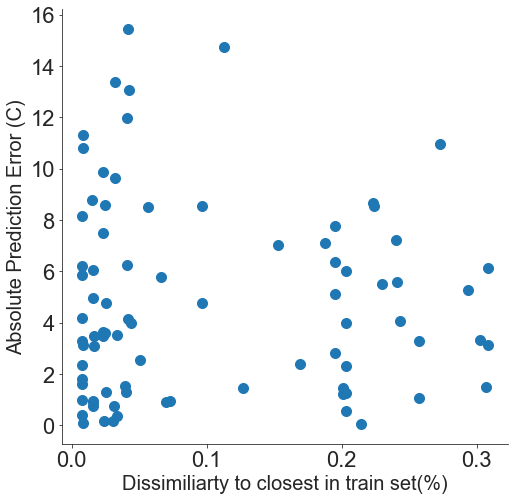

In [11]:

sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(8,8))

plt.scatter(closest_mut_to_ref, errors, s=100)
plt.xlabel(f"Dissimiliarty to closest in train set(%)", fontsize=20)
plt.ylabel(f"Absolute Prediction Error (C)", fontsize=20)
#plt.title(f"Measured Melting Temperature \naverage Tm = {mean_tm}", fontsize=18, y=1.02)
plt.tick_params(bottom=True, left=True, labelsize=22)

plt.show()
plt.close()

results['Abs Error'] = errors

$r$ = 0.751, $\rho$ = 0.741, MAE = 4.77 
std_ratio = 0.878


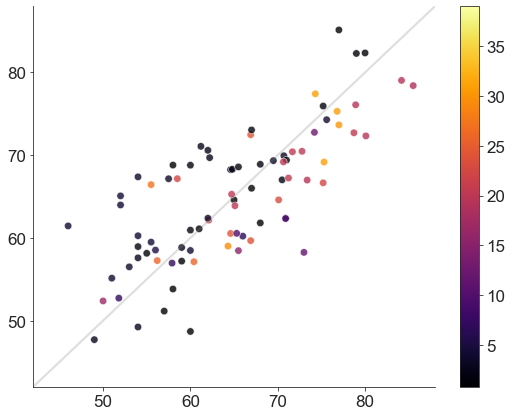

83


In [12]:
from sklearn.metrics import mean_absolute_error
import matplotlib.cm as cm

def perf_metrix(predictions: list, true_values: list):
    '''Compute various prediction performances metrics.'''
    
    pearson, pearson_p = scipy.stats.pearsonr(predictions, true_values)
    spearman, spearman_p = scipy.stats.spearmanr(predictions, true_values)
    mae = mean_absolute_error(predictions, true_values)
    
    pearson = float("{0:.3g}".format(pearson))
    pearson_p = float("{0:.3g}".format(pearson_p))
    spearman = float("{0:.3g}".format(spearman))
    spearman_p = float("{0:.3g}".format(spearman_p))
    mae = float("{0:.3g}".format(mae))
    std_ratio = float("{0:.3g}".format(np.std(predictions)/np.std(true_values)))
    
    return pearson, pearson_p, spearman, spearman_p, mae


# Plot error bars
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
fig, ax = plt.subplots(figsize=(9, 7))
palette="tab10"

ax.plot([0,200], [0,200], '-', color='grey', alpha=0.25, linewidth=2.2)

for i in range(len(df_res)):
    ax.errorbar(df_res['true'][i], df_res['pred'][i], fmt='none', linewidth=2, alpha=0.15)

# Assuming df_res has columns: 'true', 'pred', 'err', and 'hue_variable'
hue_variable = np.array([round(c*100,1) for c in closest_mut_to_ref]) # Replace with the actual column name or array you want to map to the color

# Normalize the hue variable to the range [0, 1] for color mapping
norm = plt.Normalize(hue_variable.min(), 39)
cmap = cm.inferno # Choose a colormap

# Scatter plot of predictions
plotscatter = sns.scatterplot(df_res, x='true', y='pred', color=cmap(norm(hue_variable)), ax=ax, alpha=0.8,s=55)

# Set title and labels
pearson_latex = r'$r$'
spearman_latex = r'$\rho$'
ax.set_ylabel('', fontsize=22)
ax.set_xlabel('', fontsize=22)
ax.set_xlim(42,88)
ax.set_ylim(42,88)

# Generate ticks for both axes

ticks = [50,60,70,80]
ax.set_xticks(ticks)
ax.set_yticks(ticks)


std_ratio = "{0:.3g}".format(np.std(df_res['pred'])/np.std(df_res['true']))
pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(df_res['pred'], df_res['true'])

print(f"{pearson_latex} = {pearson}, {spearman_latex} = {spearman}, MAE = {rmse} \nstd_ratio = {std_ratio}")
plt.tick_params(bottom=True, left=True, labelsize=22)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

legend = plt.legend(title='', ncol=2, fontsize=22, markerscale=2,
            loc='lower right' , handletextpad=0.1, columnspacing=1.0, frameon=False)
cbar = plt.colorbar(sm, ax=ax)
font_size=17
cbar.ax.tick_params(labelsize=font_size)
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)


# cbar.set_label('Closest Dissim with train database (%)',fontsize=22,)
plt.savefig('figures/figure6b.png', dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

print(len(df_res))

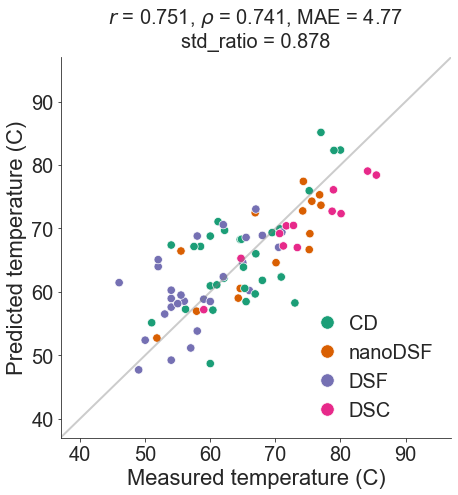

3.884166666666671
12


In [13]:
from sklearn.metrics import mean_absolute_error
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

# Plot error bars
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot([0,200], [0,200], '-', color='grey', alpha=0.4, linewidth=2)

# Create a pastel colormap
pastel_palette = sns.color_palette("Dark2")  # Choose a pastel color palette
pastel_cmap = ListedColormap(pastel_palette.as_hex())

# Map the colormap to the 'hue' variable categories
label = 'method'
unique_methods = df_res[label].unique()
pastel_palette = {method: pastel_palette[i % len(pastel_palette)] for i, method in enumerate(unique_methods)}

# Scatter plot of predictions
plotscatter = sns.scatterplot(df_res, x='true', y='pred', hue=label, palette=pastel_palette, ax=ax, alpha=1,s=70)
# Set title and labels
pearson_latex = r'$r$'
spearman_latex = r'$\rho$'
ax.set_ylabel('Predicted temperature (C)', fontsize=22)
ax.set_xlabel('Measured temperature (C)', fontsize=22)
ax.set_xlim(37,97)
ax.set_ylim(37,97)


std_ratio = "{0:.3g}".format(np.std(df_res['pred'])/np.std(df_res['true']))
pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(df_res['pred'], df_res['true'])

ax.set_title(f"{pearson_latex} = {pearson}, {spearman_latex} = {spearman}, MAE = {rmse} \nstd_ratio = {std_ratio}", y=1.01, fontsize=20)

plt.tick_params(bottom=True, left=True, labelsize=20)


legend = plt.legend(title='', ncol=1, fontsize=20, markerscale=1.6,
            loc='lower right' , handletextpad=0.1, columnspacing=0, frameon=False)

plt.savefig('./figures/figureS14.png', dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

mean = np.mean(np.abs(np.array(df_res[df_res['method']=='DSC']['true']) - np.array(df_res[df_res['method']=='DSC']['pred'])))
print(mean)
print(len(np.abs(np.array(df_res[df_res['method']=='DSC']['true']) - np.array(df_res[df_res['method']=='DSC']['pred']))))

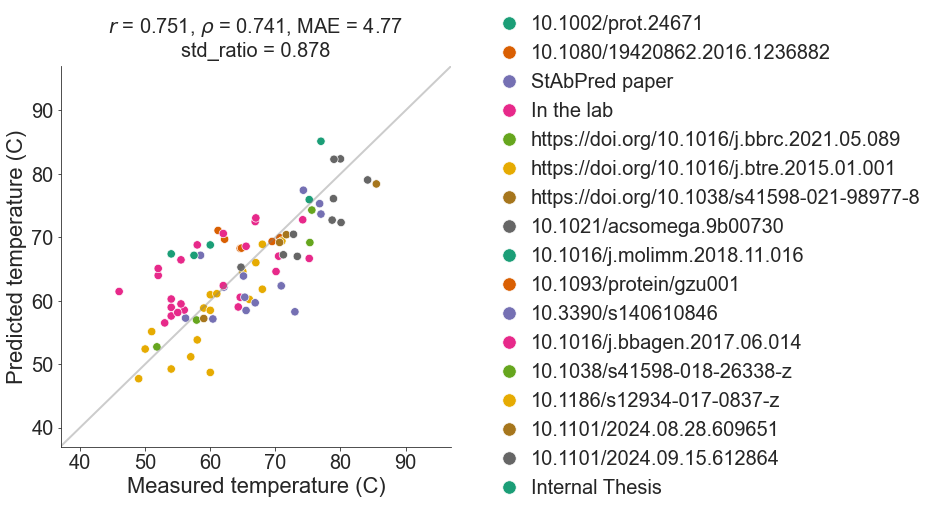

In [14]:
from sklearn.metrics import mean_absolute_error
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

# Plot error bars
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot([0,200], [0,200], '-', color='grey', alpha=0.4, linewidth=2)

# Create a pastel colormap
pastel_palette = sns.color_palette("Dark2")  # Choose a pastel color palette
pastel_cmap = ListedColormap(pastel_palette.as_hex())

# Map the colormap to the 'hue' variable categories
label = 'source'
unique_methods = df_res[label].unique()
pastel_palette = {method: pastel_palette[i % len(pastel_palette)] for i, method in enumerate(unique_methods)}

# Scatter plot of predictions
plotscatter = sns.scatterplot(df_res, x='true', y='pred', hue=label, palette=pastel_palette, ax=ax, alpha=1,s=70)
# Set title and labels
pearson_latex = r'$r$'
spearman_latex = r'$\rho$'
ax.set_ylabel('Predicted temperature (C)', fontsize=22)
ax.set_xlabel('Measured temperature (C)', fontsize=22)
ax.set_xlim(37,97)
ax.set_ylim(37,97)


std_ratio = "{0:.3g}".format(np.std(df_res['pred'])/np.std(df_res['true']))
pearson, pearson_p, spearman, spearman_p, rmse = perf_metrix(df_res['pred'], df_res['true'])

ax.set_title(f"{pearson_latex} = {pearson}, {spearman_latex} = {spearman}, MAE = {rmse} \nstd_ratio = {std_ratio}", y=1.01, fontsize=20)

plt.tick_params(bottom=True, left=True, labelsize=20)


legend = plt.legend(title='', ncol=1, fontsize=20, markerscale=1.6,
            loc='center left',  # Position legend to the left of bbox anchor
    bbox_to_anchor=(1.05, 0.5),   handletextpad=0.1, columnspacing=0, frameon=False)

# plt.savefig('./figures/ext_test_plot.png', dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()